In [1]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime, timedelta
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [5]:
weather=pd.read_csv('../data/weather.csv')
weather.date_time = pd.to_datetime(weather.date_time)
weather.set_index('date_time', inplace=True)

In [6]:
df=pd.read_csv('../data/LA.csv')
df["start_time"] = pd.to_datetime(df['start_time'])
df["end_time"] = pd.to_datetime(df['end_time'] ) 
df.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_duration,trip_duration_in_hours
0,2018-01-01 00:04:00,2018-01-01 00:25:00,3063,3018,5889,Walk-up,Pershing Square,Grand & Olympic,0 days 00:21:00,0.350000
1,2018-01-01 00:05:00,2018-01-01 00:25:00,3063,3018,6311,Walk-up,Pershing Square,Grand & Olympic,0 days 00:20:00,0.333333
2,2018-01-01 00:06:00,2018-01-01 00:25:00,3063,3018,5753,Walk-up,Pershing Square,Grand & Olympic,0 days 00:19:00,0.316667
3,2018-01-01 00:13:00,2018-01-01 00:35:00,3018,3031,6220,Monthly Pass,Grand & Olympic,7th & Spring,0 days 00:22:00,0.366667
4,2018-01-01 00:14:00,2018-01-01 00:59:00,4204,4216,12436,Monthly Pass,Washington & Abbot Kinney,17th St / SMC E Line Station,0 days 00:45:00,0.750000


### Utilization based on trips per hour

We use trips taken per hour divided by bike fleet size of the transporation agency Metro as a KPI to estimate the fleet's utilization. We thereby count all trips occouring in the span of an hour, including trips that start in the respective hour as well as trips that are ongiong. The KPI calculates the percentage of the bike fleet utilized if all where taken with distinct bikes. It tells us how many bikes would be needed at most to supply the observed demand.

In [7]:
#data frame: count starts and ends of trips
trips_started = df.start_time.value_counts()
trips_ended = df.end_time.value_counts()
trip_count =  pd.concat([trips_started, trips_ended],axis = 1)
trip_count.rename(columns = {'start_time':'trips_started','end_time':'trips_ended'}, inplace = True)
trip_count.fillna(0, inplace = True)
    
#add trips starting/ending since the last entry, amount of trips occouring at one time
trip_count['difference_to_last_entry'] = trip_count.trips_started - trip_count.trips_ended
trip_count['trips_occuring'] = trip_count.trips_started.cumsum() - trip_count.trips_ended.cumsum()
trip_count

,trips_started,trips_ended,difference_to_last_entry,trips_occuring
2018-01-01 00:04:00,1.0,0.0,1.0,1.0
2018-01-01 00:05:00,1.0,0.0,1.0,2.0
2018-01-01 00:06:00,1.0,0.0,1.0,3.0
2018-01-01 00:13:00,1.0,0.0,1.0,4.0
2018-01-01 00:14:00,2.0,0.0,2.0,6.0
...,...,...,...,...
2019-01-01 00:02:00,0.0,2.0,-2.0,5.0
2019-01-01 00:20:00,0.0,1.0,-1.0,4.0
2019-01-01 00:22:00,0.0,2.0,-2.0,2.0
2019-01-01 00:24:00,0.0,1.0,-1.0,1.0


The indicator trips per hour is calcluated as the sum of trips starting in the respective hour and the trips that started in a previous hour and are still occour in the respective hour.

In [8]:
trips_ongoing = trip_count.trips_occuring.resample('H').first().fillna(method ='ffill') 
- trip_count.difference_to_last_entry.resample('H').first().fillna(0)
trips_new = trip_count.trips_started.resample('H').sum().fillna(0)
trips_per_hour = trips_ongoing + trips_new
trips_per_hour

2018-01-01 00:00:00    26.0
2018-01-01 01:00:00    34.0
2018-01-01 02:00:00    23.0
2018-01-01 03:00:00     5.0
2018-01-01 04:00:00     6.0
                       ... 
2018-12-31 21:00:00    34.0
2018-12-31 22:00:00    29.0
2018-12-31 23:00:00    24.0
2019-01-01 00:00:00     5.0
2019-01-01 01:00:00     0.0
Freq: H, Length: 8762, dtype: float64

The KPI of maximum utilization is calculated as trips taken in an hour devided by the number of distinct bikes in the fleet. It indicated the pecentage of the bike fleet utilized, if all trips occouring in an hour are taken with a different bike. 

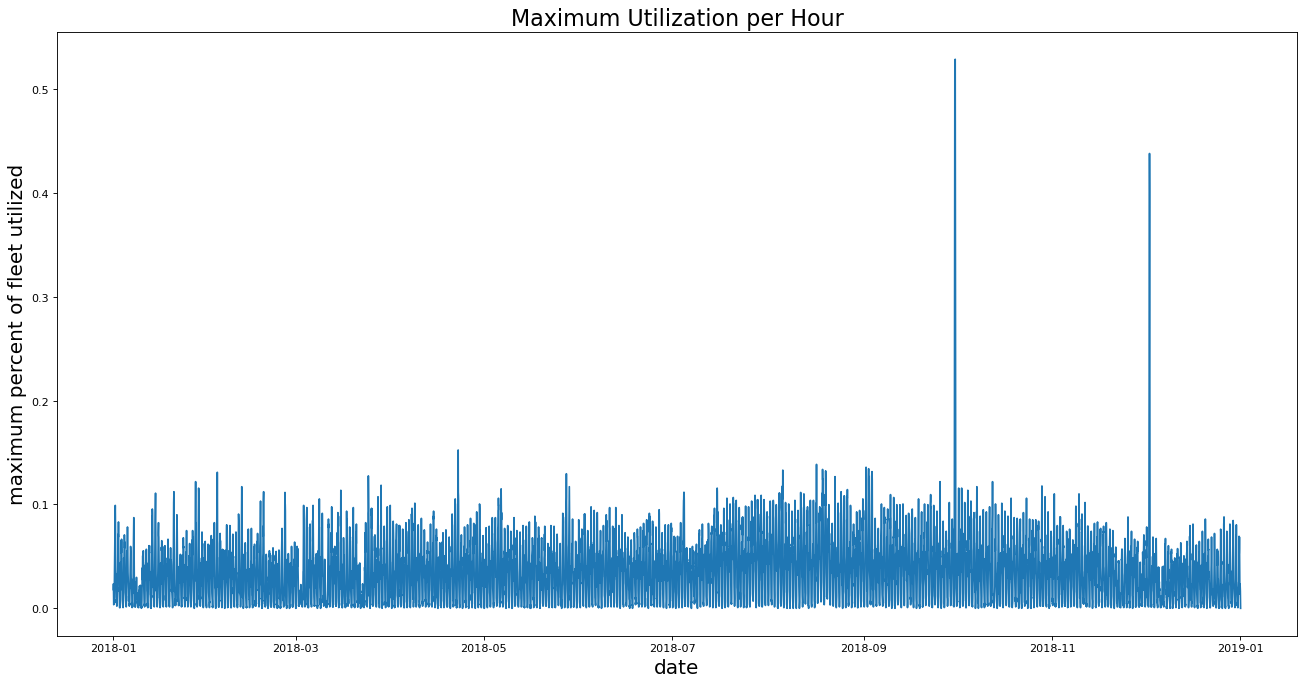

In [9]:
max_utilization = pd.DataFrame(trips_per_hour/ df["bike_id"].nunique(), columns = ['max_utilization'])

fig,ax = plt.subplots(figsize=(20,10), dpi= 80) 
axis_font = {'size':'18'}
dic={'fontsize': '20'}

ax.plot(max_utilization, color = 'tab:blue')
ax.set_title("Maximum Utilization per Hour", dic)
ax.set_ylabel('maximum percent of fleet utilized',**axis_font)
ax.set_xlabel('date',**axis_font)
plt.show()

Peek utilization: <br>30.9 = CicLAvia x LA Phil 100 -> up to more that 50 percent utilization
<br>2.12 = CicLAvia Heart of LA -> up to more that 50 percent utilization


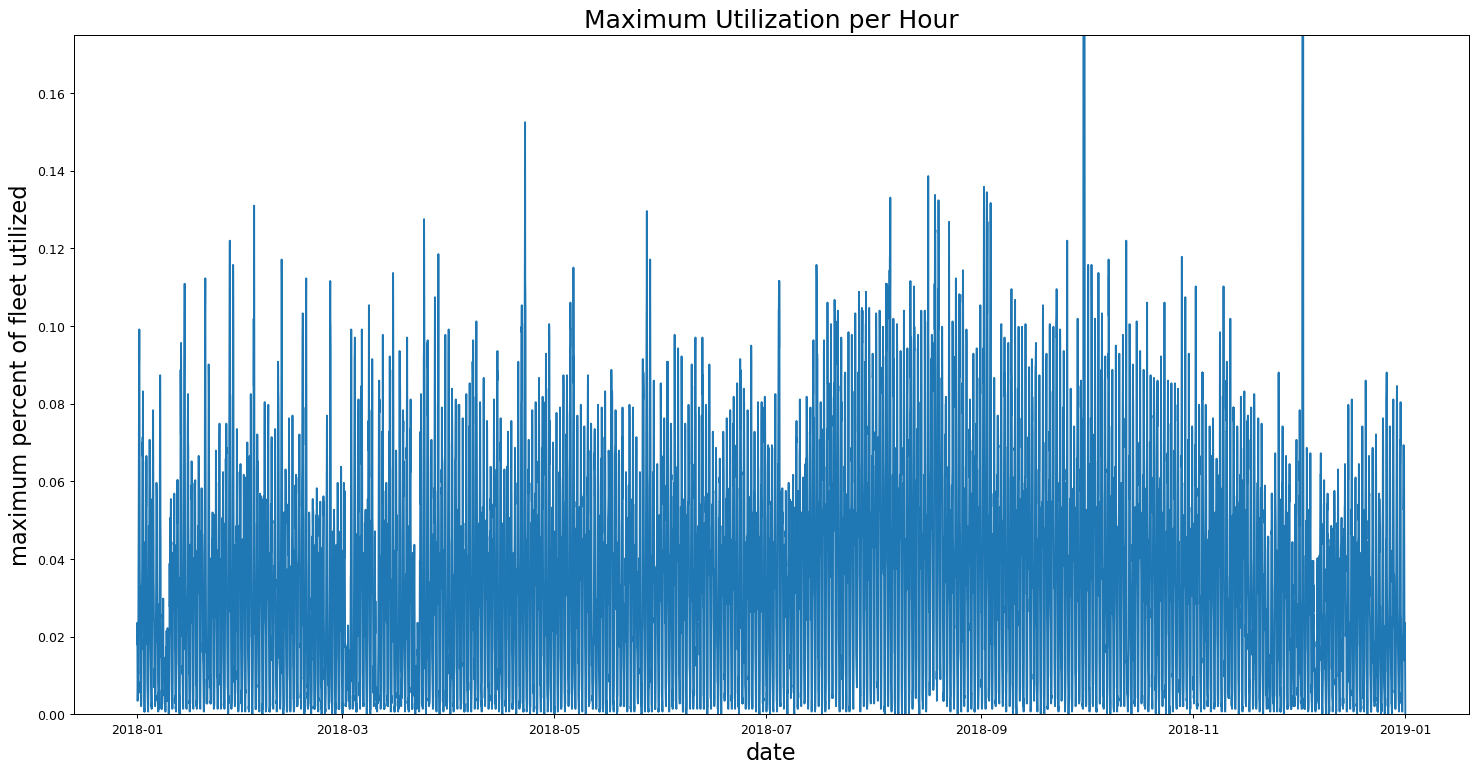

In [11]:
fig,ax = plt.subplots(figsize=(20,10), dpi= 90) 

ax.plot(max_utilization, color = 'tab:blue')
ax.set_title("Maximum Utilization per Hour", dic)
ax.set_ylabel('maximum percent of fleet utilized',**axis_font)
ax.set_xlabel('date',**axis_font)
ax.set_ylim([0,0.175])
plt.show()

todo: describe (Which trends do you observe? How do you explain them?)<br>
mo

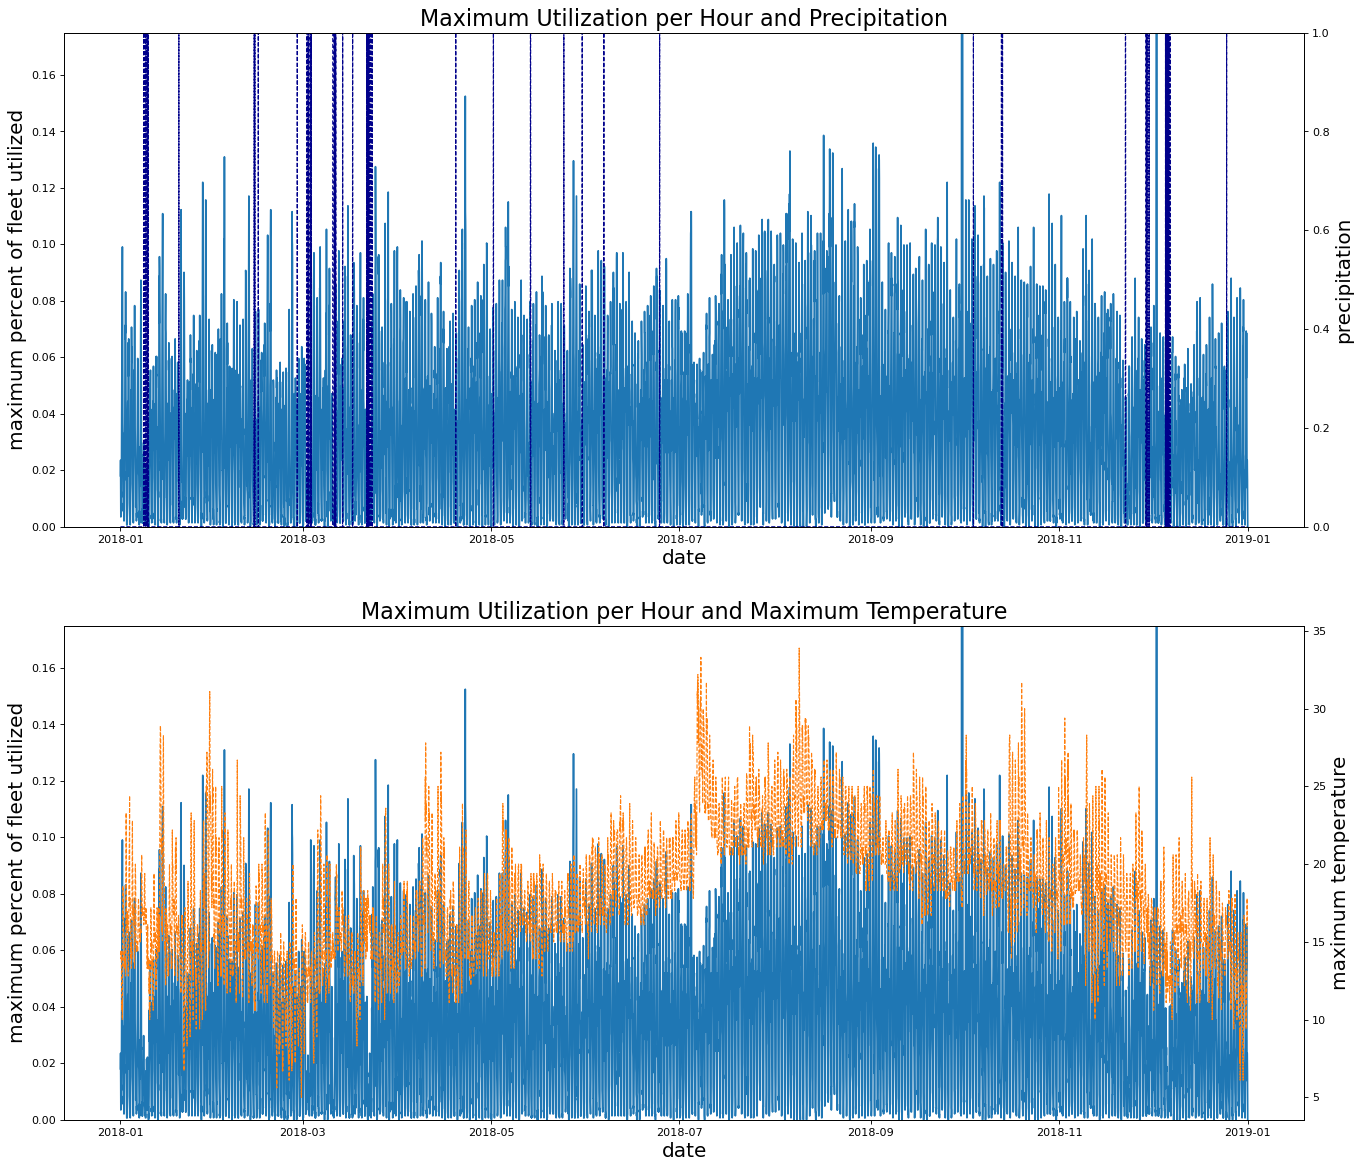

In [12]:
fig,ax1 = plt.subplots(2, 1, figsize=(20,18), dpi= 80) 
ax2 = ax1[0].twinx()

ax1[0].plot(max_utilization, color = 'tab:blue')
ax1[0].set_title("Maximum Utilization per Hour and Precipitation", dic)
ax1[0].set_ylabel('maximum percent of fleet utilized',**axis_font)
ax1[0].set_xlabel('date',**axis_font)
ax1[0].set_ylim([0,0.175])

ax2.plot(weather.precip, color = 'darkblue',linestyle = '--',linewidth=1)
ax2.set_ylabel('precipitation',**axis_font)
ax2.set_ylim([0,1])


ax2 = ax1[1].twinx()

ax1[1].plot(max_utilization, color = 'tab:blue')
ax1[1].set_title("Maximum Utilization per Hour and Maximum Temperature", dic)
ax1[1].set_ylabel('maximum percent of fleet utilized',**axis_font)
ax1[1].set_xlabel('date',**axis_font)
ax1[1].set_ylim([0,0.175])

ax2.plot(weather.max_temp, color = 'tab:orange',linestyle = '--', linewidth=1)
ax2.set_ylabel('maximum temperature',**axis_font)
#ax2.set_ylim([0,1])

plt.show()

days with very low utilization: days with precip <br>
high temperatures ( over 30 dregree) days have lower utilization<br>
lower utilization on colder days